### Imports

In [1]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

### Ground truth map mesh

In [2]:
verts, faces, aux = load_obj(os.path.join('./output/simple_tunnel_01_gz.obj'))

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

NORMALIZE_MESH = True
if NORMALIZE_MESH:
    # We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
    # (scale, center) will be used to bring the predicted mesh to its original center and scale
    # Note that normalizing the target mesh, speeds up the optimization but is not necessary!
    center = verts.mean(0)
    verts = verts - center
    scale = max(verts.abs().max(0)[0])
    verts = verts / scale

# We construct a Meshes structure for the target mesh
map_gt_mesh = Meshes(verts=[verts], faces=[faces_idx])

### Point cloud to compare

In [3]:
def plot_pointcloud(inputs, title=""):
    assert isinstance(inputs, Meshes) or isinstance(inputs, Pointclouds)
    if isinstance(inputs, Meshes):
        # Sample points uniformly from the surface of the mesh.
        points = sample_points_from_meshes(inputs, 1000)
    elif isinstance(inputs, Pointclouds):
        points = inputs.points_list()[0]
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [4]:
points = sample_points_from_meshes(map_gt_mesh, 1000)
point_cloud = Pointclouds(points)

<IPython.core.display.Javascript object>


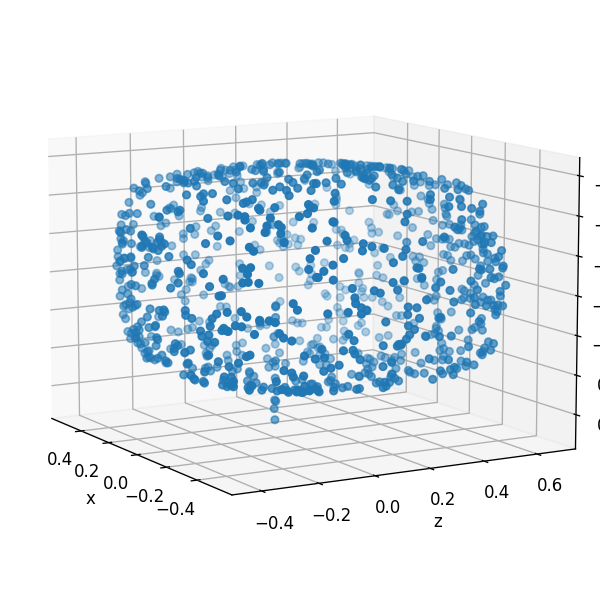

<ipython-input-3-450089479052>:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


In [5]:
plot_pointcloud(map_gt_mesh)

<IPython.core.display.Javascript object>


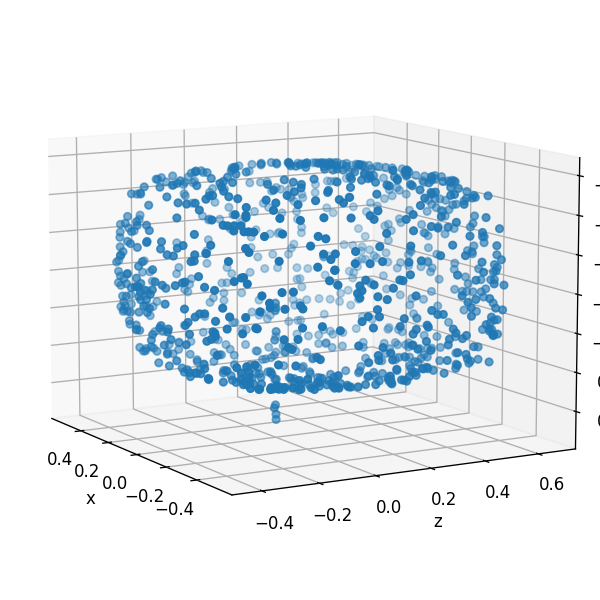

<ipython-input-3-450089479052>:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


In [6]:
plot_pointcloud(point_cloud)

### Compare mesh to point cloud

In [7]:
# Compare mesh and point cloud:
# https://pytorch3d.readthedocs.io/en/latest/modules/loss.html#pytorch3d.loss.point_mesh_edge_distance
from pytorch3d.loss import point_mesh_edge_distance, point_mesh_face_distance

In [8]:
for num_points in tqdm(range(1000, 10_000, 1000)):
    points = sample_points_from_meshes(map_gt_mesh, num_points)
    point_cloud = Pointclouds(points)

    loss_edge = point_mesh_edge_distance(meshes=map_gt_mesh, pcls=point_cloud)
    loss_face = point_mesh_face_distance(meshes=map_gt_mesh, pcls=point_cloud)
    print(f'Num sampled points: {num_points}, \
          loss_edge :{loss_edge.detach().cpu().numpy():.6f} \
          loss_face :{loss_face.detach().cpu().numpy():.6f}')

  0%|          | 0/9 [00:00<?, ?it/s]

Num sampled points: 1000,           loss_edge :0.044077           loss_face :0.001220
Num sampled points: 2000,           loss_edge :0.006039           loss_face :0.002675
Num sampled points: 3000,           loss_edge :0.000956           loss_face :0.000051
Num sampled points: 4000,           loss_edge :0.001092           loss_face :0.000070
Num sampled points: 5000,           loss_edge :0.000950           loss_face :0.000025
Num sampled points: 6000,           loss_edge :0.000883           loss_face :0.000014
Num sampled points: 7000,           loss_edge :0.000860           loss_face :0.000013
Num sampled points: 8000,           loss_edge :0.000829           loss_face :0.000013
Num sampled points: 9000,           loss_edge :0.000849           loss_face :0.000012
